# GE Notebook - LLM Prompt Recovery

Let's start by defining the scope of the work:

- Understand the Problem
- Understand the data
- Prepare the data
- Feature Engineering
- Modelling
- Evaluation
- Submission

---
## Understand the Problem

> LLMs are commonly used to rewrite or make stylistic changes to text. The goal of this competition is to recover the LLM prompt that was used to transform a given text.
> 
> NLP workflows increasingly involve rewriting text, but there's still a lot to learn about how to prompt LLMs effectively. This machine learning competition is designed to be a novel way to dig deeper into this problem.
> 
> The challenge: recover the LLM prompt used to rewrite a given text. You’ll be tested against a dataset of 1300+ original texts, each paired with a rewritten version from Gemma, Google’s new family of open models.

This problem includes a free-form start where contestants have to define and build their own training data. The example submissions give a hint as to what we should be looking for.

The process for generating training data looks as follows:

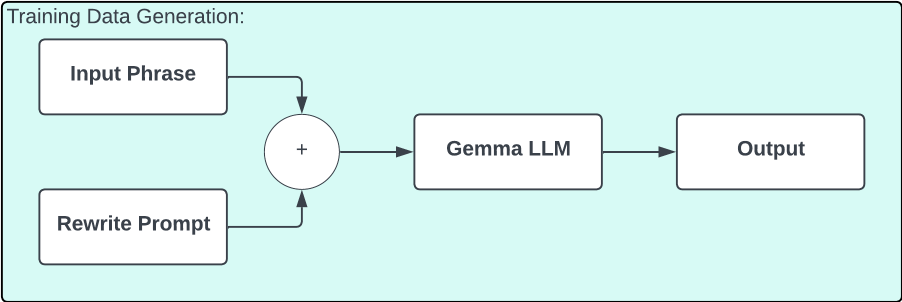

The model that I want to build will look as follows:

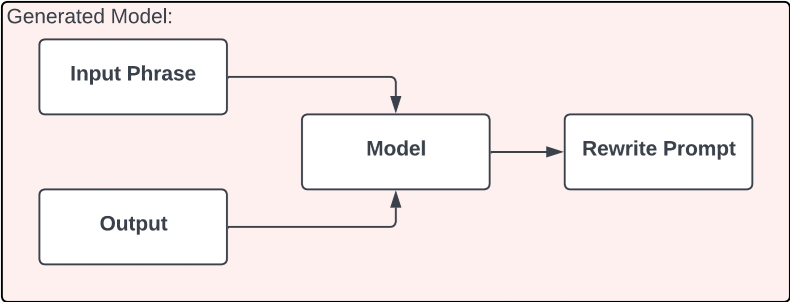

---
## Initialization

Section for imports and configurations.

In [1]:
import pandas as pd
import random
import datetime

In [2]:
# create a flag to enable or disable running cells that are required for training data generation (resource intense operations)
# True = run training data generation
# False = skip training data generation

train_data_generation = True

---
## Understand the Data

This competition has examples of testing/training data, but doesn't include any form of large dataset to train with. We have to make our own.

To do this, we will start by initializing an instance of Gemma that can be used to query and receive responses from. For this project, I will be focusing on using the latest versions of Gemma 7b-it-quant.

In [3]:
%%capture

if train_data_generation:
    
    # Setup the environment
    !pip install -q -U immutabledict sentencepiece 
    !git clone https://github.com/google/gemma_pytorch.git
    !mkdir /kaggle/working/gemma/
    !mv /kaggle/working/gemma_pytorch/gemma/* /kaggle/working/gemma/

    import sys 
    sys.path.append("/kaggle/working/gemma_pytorch/") 
    from gemma.config import GemmaConfig, get_config_for_7b, get_config_for_2b
    from gemma.model import GemmaForCausalLM
    from gemma.tokenizer import Tokenizer
    import contextlib
    import os
    import torch

    # Load the model
    VARIANT = "7b-it-quant" 
    MACHINE_TYPE = "cuda" 
    weights_dir = '/kaggle/input/gemma/pytorch/7b-it-quant/2' 

    @contextlib.contextmanager
    def _set_default_tensor_type(dtype: torch.dtype):
      """Sets the default torch dtype to the given dtype."""
      torch.set_default_dtype(dtype)
      yield
      torch.set_default_dtype(torch.float)

    # Model Config.
    model_config = get_config_for_2b() if "2b" in VARIANT else get_config_for_7b()
    model_config.tokenizer = os.path.join(weights_dir, "tokenizer.model")
    model_config.quant = "quant" in VARIANT

    # Model.
    device = torch.device(MACHINE_TYPE)
    with _set_default_tensor_type(model_config.get_dtype()):
      model = GemmaForCausalLM(model_config)
      ckpt_path = os.path.join(weights_dir, f'gemma-{VARIANT}.ckpt')
      model.load_weights(ckpt_path)
      model = model.to(device).eval()

In [4]:
if train_data_generation:
    
    # read the input CSV containing 100 ChatGPT generated "rewrite this as..." prompts
    df_rewrite_prompts = pd.read_csv('/kaggle/input/rewrite-prompts/rewrite_prompts.csv')

    # convert the 'Rewrite Prompt' column to a list
    prompt_list = df_rewrite_prompts['Rewrite Prompt'].to_list()

    # select a number of random prompts to pull from the list
    number_of_prompts = 10
    prompt_selector = random.sample(range(0,len(prompt_list)),number_of_prompts)

    # create a blank list for the prompts that will be used to build onto the training dataset
    prompts = []

    # add the randomly selected prompts to the final list
    for i in prompt_selector:
        prompts.append(prompt_list[i])

In [5]:
if train_data_generation:
    
    # read the input CSV containing both AI and human generated text
    df_movie_plot = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')

    # convert the 'text' column to a list   
    phrase_list = df_movie_plot['text'].to_list()

    # select a number of random phrases to pull from the list
    number_of_phrases = 10
    phrase_selector = random.sample(range(0,len(phrase_list)),number_of_phrases)

    # create a blank list for the phrases that will be used to build onto the training dataset
    phrases = []

    # add the randomly selected phrases to the final list
    for i in phrase_selector:
        phrases.append(phrase_list[i])

In [6]:
if train_data_generation:
    
    # This is the prompt format the model expects
    USER_CHAT_TEMPLATE = "<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"

    number_of_tries = 5

    rewrite_data = []

    for phrase in phrases:
        for prompt in prompts:
            prompt = f'{prompt}\n{phrase}'
            for n in range(number_of_tries):
                rewritten_text = model.generate(
                    USER_CHAT_TEMPLATE.format(prompt=prompt),
                    device=device,
                    output_len=100,
                )
                rewrite_data.append({
                    'phrase': phrase,
                    'prompt': prompt,
                    'rewritten_text': rewritten_text,
                }) 

In [7]:
if train_data_generation:
    
    df_train_outputs = pd.DataFrame(rewrite_data)
    df_train_outputs.head()

In [8]:
if train_data_generation:
    
    output_csv_path = f'LLM_train_output_{datetime.datetime.now().strftime("%m%d%Y")}.csv'
    df_train_outputs.to_csv(output_csv_path, index=False)

---
## Prepare the Data

Take the generated data, and process it for use in modelling.

In [9]:
df1 = pd.read_csv('/kaggle/input/rewrite-prompts/LLM_train_output_0418_03012024.csv')
df2 = pd.read_csv('/kaggle/input/rewrite-prompts/LLM_train_output_0007_03022024.csv')

df_train = pd.concat([df1, df2], ignore_index=True)

In [10]:
df_train.head()

,phrase,prompt,rewritten_text
0,sometimes talking to more than one person get ...,Imbue this with a dash of F. Scott Fitzgerald\...,"Sure, here's the text infused with a dash of F..."
1,sometimes talking to more than one person get ...,Imbue this with a dash of F. Scott Fitzgerald\...,"Sure, here's the text infused with a dash of F..."
2,sometimes talking to more than one person get ...,Imbue this with a dash of F. Scott Fitzgerald\...,"Sure, here's the text infused with a dash of F..."
3,sometimes talking to more than one person get ...,Imbue this with a dash of F. Scott Fitzgerald\...,A toast to the transformative power of engagin...
4,sometimes talking to more than one person get ...,Imbue this with a dash of F. Scott Fitzgerald\...,"Sure, here's the text imbued with a dash of F...."


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   phrase          1000 non-null   object
 1   prompt          1000 non-null   object
 2   rewritten_text  1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


In [12]:
df_train.isnull().sum()

phrase            0
prompt            0
rewritten_text    0
dtype: int64

In [13]:
phrase_duplicates = df_train.duplicated(subset=['phrase']).sum()
prompt_duplicates = df_train.duplicated(subset=['prompt']).sum()
rewritten_text_duplicates = df_train.duplicated(subset=['rewritten_text']).sum()

print('Number of duplicate phrases: ' + str(phrase_duplicates))
print('Number of duplicate prompts: ' + str(prompt_duplicates))
print('Number of duplicate responses: ' + str(rewritten_text_duplicates))

Number of duplicate phrases: 980
Number of duplicate prompts: 800
Number of duplicate responses: 8


In [14]:
df_train[df_train.duplicated(keep=False)]

,phrase,prompt,rewritten_text
11,sometimes talking to more than one person get ...,Adjust the emotional intensity of the text. If...,**Original Text:**\n\nSometimes talking to mor...
14,sometimes talking to more than one person get ...,Adjust the emotional intensity of the text. If...,**Original Text:**\n\nSometimes talking to mor...
211,Extracurricular activities are important to yo...,Adjust the emotional intensity of the text. If...,**Original Text:**\n\nExtracurricular activiti...
213,Extracurricular activities are important to yo...,Adjust the emotional intensity of the text. If...,**Original Text:**\n\nExtracurricular activiti...
311,"Dear Mrs. Barker,\n\nI'm writing to you today ...",Adjust the emotional intensity of the text. If...,"**Original Text:**\n\nDear Mrs. Barker,\n\nI'm..."
314,"Dear Mrs. Barker,\n\nI'm writing to you today ...",Adjust the emotional intensity of the text. If...,"**Original Text:**\n\nDear Mrs. Barker,\n\nI'm..."
360,Benefits of Student designed Projects\n\nSumme...,Adjust the emotional intensity of the text. If...,**Original Text:**\n\nBenefits of Student Desi...
361,Benefits of Student designed Projects\n\nSumme...,Adjust the emotional intensity of the text. If...,**Original Text:**\n\nBenefits of Student Desi...
363,Benefits of Student designed Projects\n\nSumme...,Adjust the emotional intensity of the text. If...,**Original Text:**\n\nBenefits of Student Desi...
364,Benefits of Student designed Projects\n\nSumme...,Adjust the emotional intensity of the text. If...,**Original Text:**\n\nBenefits of Student Desi...


In [15]:
print('First duplicate: \n'+ df_train.iloc[11,2] + '\n')
print('Second duplicate: \n' + df_train.iloc[14,2])

First duplicate: 
**Original Text:**

Sometimes talking to more than one person can get you threw a lot of things in life and help you become a better person as well. Also seeking multiple opinions and advises can help you think about how to or make better choices by thinking more wisely before doing something that may look or sound like a better choice to you but might actually be a bad choice. And think about the consequences you will have If you don't decide to make the right choices.

**Subdued Text

Second duplicate: 
**Original Text:**

Sometimes talking to more than one person can get you threw a lot of things in life and help you become a better person as well. Also seeking multiple opinions and advises can help you think about how to or make better choices by thinking more wisely before doing something that may look or sound like a better choice to you but might actually be a bad choice. And think about the consequences you will have If you don't decide to make the right choic

***Interesting!***

Sometimes Gemma begins the response by stating the original text in a given format. Because of this, we likely don't see any actual response. The input prompt is too long, and Gemma runs into the max output of 100 words before the model can provide any new or novel text.

Since this is such a small number of data points that have this happen, I think it's easiest to trim them from our training data moving forward.

In [16]:
df_train = df_train.drop_duplicates(subset=['rewritten_text'], keep=False)

rewritten_text_duplicates = df_train.duplicated(subset=['rewritten_text']).sum()
print('Number of duplicate responses: ' + str(rewritten_text_duplicates))

Number of duplicate responses: 0


---
## Feature Engineering

Explore steps for processing data to improve modelling. Outlier rejection, data scaling, etc.

---
## Modelling

Create the model and such that will be used for the prediction

---
## Evaluation

Use the problem definition to evaluate the model against a private test dataset.